# Using SeqIKPy for Drosophila grooming

In this tutorial, we will use `seqikpy` to perform inverse kinematics on a grooming data.

In [1]:
%autoreload 2
# Import the necessary libraries

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from seqikpy.data import PTS2ALIGN
from seqikpy.utils import load_file, save_file, calculate_body_size, dict_to_nparray_pose
from seqikpy.alignment import AlignPose, convert_from_anipose_to_dict
from seqikpy.kinematic_chain import KinematicChainSeq
from seqikpy.head_inverse_kinematics import HeadInverseKinematics
from seqikpy.leg_inverse_kinematics import LegInvKinSeq
from seqikpy.visualization import plot_3d_points, animate_3d_points

# Set up the constant variables
leg_joint_angle_names = [
    "ThC_yaw",
    "ThC_pitch",
    "ThC_roll",
    "CTr_pitch",
    "CTr_roll",
    "FTi_pitch",
    "TiTa_pitch",
]
legs_to_align = ["RF","LF"]

In [2]:
# Load the data, below contains the kinematics during locomotion
data_path = Path("../data/anipose_pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh")
pose_data = load_file(
    data_path / "pose3d.h5"
)

# Convert the dictionary in a compatible format
converted_dict_full = convert_from_anipose_to_dict(pose_data, pts2align=PTS2ALIGN)

# Select the time period where locomotion happens
converted_dict = {}
for key, dict_v in converted_dict_full.items():
    converted_dict[key] = dict_v[400:600,:,:]

# Defining the body model

It is very challenging to precisely define the joint rotational axes in Drosophila due to the complex structure of their exoskeleton. Here, we make use of a previously published biomechanical model of Drosophila melonagestor, [NeuroMechFly](https://github.com/NeLy-EPFL/NeuroMechFly). Specifically, we identified the 3D points corresponding to each joint on the biomechanical body, and use this information to transform the real animal 3D data into the biomechanical model's frame of reference.

 <p style="text-align: center;">
    <img src="./images/NMF_zero_pose.png" alt="Biomechanical model" width="600"/>
    <br>
    <em>Biomechanical model</em>
    <br>
 </p>

In [3]:
TEMPLATE_NMF_GROOMING = {
    "RF_Coxa": np.array([0.33, -0.17, 1.07]),
    "RF_Femur": np.array([0.33, -0.17, 0.67]),
    "RF_Tibia": np.array([0.33, -0.17, -0.02]),
    "RF_Tarsus": np.array([0.33, -0.17, -0.56]),
    "RF_Claw": np.array([0.33, -0.17, -1.19]),
    "LF_Coxa": np.array([0.33, 0.17, 1.07]),
    "LF_Femur": np.array([0.33, 0.17, 0.67]),
    "LF_Tibia": np.array([0.33, 0.17, -0.02]),
    "LF_Tarsus": np.array([0.33, 0.17, -0.56]),
    "LF_Claw": np.array([0.33, 0.17, -1.19]),
    "R_Antenna_base": np.array([1.01, -0.10, 1.41]),
    "L_Antenna_base": np.array([1.01, 0.10, 1.41]),
    "R_Antenna_edge": np.array([1.06, -0.10, 1.14]),
    "L_Antenna_edge": np.array([1.06, 0.10, 1.14]),
    "R_wing": np.array([0.08, -0.4, 1.43]),
    "L_wing": np.array([0.08, 0.4, 1.43]),
    "Neck": np.array([0.53, 0.0, 1.3]),
    "Thorax_mid": np.array([0.08, 0.0, 1.43]),
}

# Aligning the 3D pose data 

The alignment process serves two purposes: 
1. Transforming the 3D pose data to the biomechanical model's frame of reference.
2. (Optional) scaling the animal 3D data to match the size of the biomechanical model if the biomechanical model's size is given to the `AlignPose` class. This option is useful if you want to scale all of your data to one body size, or if you want to perform kinematic replay in simulation using the body model. Alternatively, the user can provide the experimental animal's body size into the class. In that case, the scaling will ensure that the animal's limb size is the same throughout the trial duration.

In [4]:
# lets align the pose
align = AlignPose(
    pose_data_dict=converted_dict,
    legs_list=legs_to_align,
    include_claw=False,
    body_template=TEMPLATE_NMF_GROOMING,
    # if body_size is none, then the size will be
    # calculated from the template
    body_size=None,
    log_level="INFO"
)

aligned_pos = align.align_pose(export_path=data_path)

 2024-02-14 16:20:38,905 - INFO- Scale factor antenna base R: 3.299136588367448, ant itself: 3.0696614255829213
 2024-02-14 16:20:38,909 - INFO- Scale factor for RF leg: 3.3732827141008928
 2024-02-14 16:20:38,912 - INFO- Scale factor antenna base L: 3.267804996386114, ant itself: 3.216483887152704
 2024-02-14 16:20:38,914 - INFO- Scale factor for LF leg: 3.199567458065388
 2024-02-14 16:20:38,917 - INFO- Aligned pose is saved at ../data/anipose_pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh


# Head inverse kinematics

As the head consists of two different joints (antennae) connected to a link (head), it is impossible to calculate inverse kinematics using the kinematic chain method without losing accuracy on one antenna. Therefore, we adopt a "dot product" method to calculate the angle between two vectors. 

In [5]:
class_hk = HeadInverseKinematics(
    aligned_pos=aligned_pos,
    body_template=TEMPLATE_NMF_GROOMING,
)
head_joint_angles = class_hk.compute_head_angles(
    export_path=data_path,
    compute_ant_angles=True
)

 2024-02-14 16:20:38,962 - INFO- Head joint angles are saved at ../data/anipose_pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh!


# Sequential Inverse Kinematics

Below, we will start the inverse kinematics process using `seqikpy`
The initial step is to determine the initial seeds for the first time step. While it is not crucial to have good initial seeds, having initial values out of the joint DOF limits will raise an error.

In [6]:
# We are defining a set of initial seeds for the IK optimization
INITIAL_ANGLES_GROOMING = {
    "RF": {
        # Base ThC yaw pitch CTr pitch
        "stage_1": np.array([0.0, 0.45, -0.07, -2.14]),
        # Base ThC yaw pitch roll CTr pitch CTr roll
        "stage_2": np.array([0.0, 0.45, -0.07, -0.32, -2.14, 1.4]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch
        "stage_3": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch TiTa pitch
        "stage_4": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },
    # Same order for the contralateral leg
    "LF": {
        "stage_1": np.array([0.0, -0.45, -0.07, -2.14]),
        "stage_2": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },
}

Secondly, we need to define some lower and upper limits for the joints. Again, having informative bounds is helpful to prevent singularities in the optimization. For example, Tibia-tarsus pitch joint should not exceed 0 degrees (always negative since the rotation is clockwise). So, it makes sense to assign an upper limit of 0 degrees for this joint.

In [7]:
# We determine the bounds for each joint DOF
BOUNDS_GROOMING = {
    "RF_ThC_roll": (np.deg2rad(-130), np.deg2rad(50)),
    "RF_ThC_yaw": (np.deg2rad(-50), np.deg2rad(50)),
    "RF_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "RF_CTr_pitch": (np.deg2rad(-180), np.deg2rad(0)),
    "RF_CTr_roll": (np.deg2rad(-150), np.deg2rad(0)),
    "RF_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "RF_TiTa_pitch": (np.deg2rad(-150), np.deg2rad(0)),
    "LF_ThC_roll": (np.deg2rad(-50), np.deg2rad(130)),
    "LF_ThC_yaw": (np.deg2rad(-50), np.deg2rad(50)),
    "LF_ThC_pitch": (np.deg2rad(-40), np.deg2rad(60)),
    "LF_CTr_pitch": (np.deg2rad(-180), np.deg2rad(0)),
    "LF_CTr_roll": (np.deg2rad(0), np.deg2rad(150)),
    "LF_FTi_pitch": (np.deg2rad(0), np.deg2rad(170)),
    "LF_TiTa_pitch": (np.deg2rad(-150), np.deg2rad(0)),
}

## Run sequential inverse kinematics

In [8]:
# Initialize the necessary classes
kin_chain = KinematicChainSeq(
    bounds_dof=BOUNDS_GROOMING,
    body_size=calculate_body_size(
        TEMPLATE_NMF_GROOMING,
        legs_list=legs_to_align
    ),
    legs_list=legs_to_align,
)

class_seq_ik = LegInvKinSeq(
    aligned_pos=aligned_pos,
    kinematic_chain_class=kin_chain,
    initial_angles=INITIAL_ANGLES_GROOMING,
    log_level="INFO",
)

The below code will commence the IK process, which consists of four stages per kinematic chain. For more details, please visit the methodology page.

After the process is over, `run_ik_and_fk` will save the results in two separete .pkl files:
* `leg_joint_angles.pkl` -> pickle file that contains the leg joint angles
* `forward_kinematics.pkl` -> 3D position of the legs construction from the calculated leg joint angles, useful for visualization and debugging purposes

In [9]:
leg_joint_angles, forward_kinematics = class_seq_ik.run_ik_and_fk(
    export_path=data_path,
    hide_progress_bar=True
)

 2024-02-14 16:20:39,080 - INFO- Computing joint angles and forward kinematics...
 2024-02-14 16:21:43,655 - INFO- Joint angles and forward kinematics are saved at ../data/anipose_pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh


# 2D visualization of the joint angles

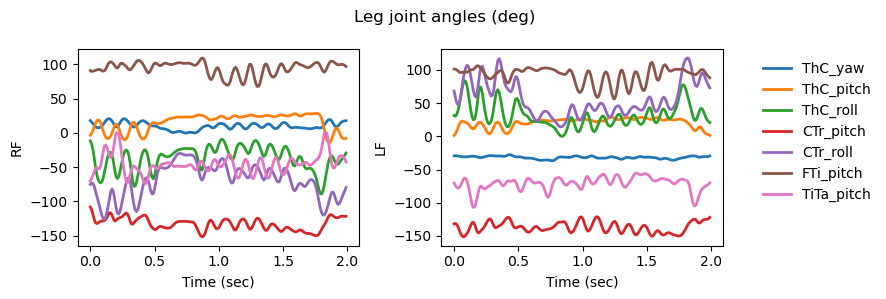

In [10]:
# Let's plot the joint angles for all six legs
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=100)

axs = axs.flatten()
for angle_name in leg_joint_angle_names:
    for i, leg_name in enumerate(["RF", "LF"]):
        axs[i].plot(
            np.rad2deg(leg_joint_angles[f"Angle_{leg_name}_{angle_name}"]),
            label=angle_name,
            lw=2,
        )
        axs[i].set_ylabel(leg_name)

time_step = 1e-2
for ax in axs:
    ax.set_xticklabels(np.array(ax.get_xticks() * time_step, dtype='f'))


axs[-1].set_xlabel("Time (sec)")
axs[-2].set_xlabel("Time (sec)")

axs[1].legend(bbox_to_anchor=(1.1, 1), frameon=False)

plt.suptitle("Leg joint angles (deg)")
plt.tight_layout()
plt.show()

# Animation of the target 3D pose and the forward kinematics


In [11]:
n_frames = 200 
# change the neck points to an array
aligned_pos['Neck'] = np.tile(aligned_pos['Neck'], (n_frames, 1, 1))


 2024-02-14 16:21:44,033 - INFO- Making animation...
 2024-02-14 16:21:48,772 - INFO- Animation is saved at ../data/anipose_pose-220807_aJO-GAL4xUAS-CsChr_Fly002_002_Beh/fk_ik_elev_10_azim_0.mp4


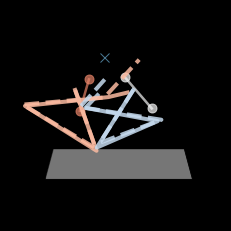

In [12]:
azim=0
elev=10

animate_3d_points(
    points3d=aligned_pos,
    points3d_second=forward_kinematics,
    export_path=data_path / f'fk_ik_elev_{elev}_azim_{azim}.mp4',
    frame_no=n_frames,
    elev=elev,
    azim=azim,
    fps=100,
)


### Original 3D pose (solid) F.K. (dashed)
![grooming](./images/grooming.gif)


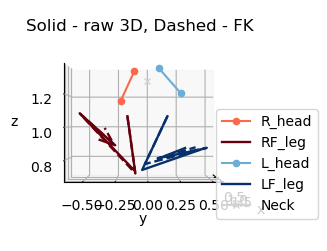

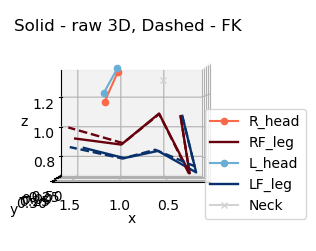

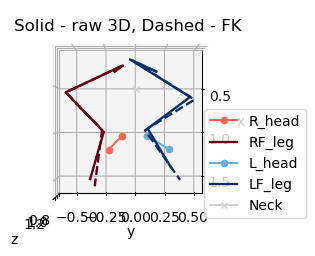

In [17]:
# If wanted, you can save each frame as a png file

plt.style.use('default')
t = 50
for azim, elev in [(0,0),(90,0),(0,90)]:
    fig = plt.figure(figsize=(3,3),dpi=100)
    ax3d = fig.add_subplot(projection='3d')
    ax3d.view_init(azim=azim, elev=elev)

    ax3d.set_xlabel('x')
    ax3d.set_ylabel('y')
    ax3d.set_zlabel('z')

    plot_3d_points(
        ax3d,
        aligned_pos,
        t=t,
        line_style='solid'
    )
    ax3d.legend(bbox_to_anchor=(1.3,0.6))

    plot_3d_points(
        ax3d,
        forward_kinematics,
        t=t,
        line_style='--'
    )
    
    ax3d.set_title('Solid - raw 3D, Dashed - FK', y=0.95)
    plt.show()

